In [1]:
#!/usr/bin/env python
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pearson import pearson
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors, KDTree, KernelDensity
from scipy.integrate import dblquad

In [2]:
def get_norm(x):
    """ Función devuelve la norma euclidiana de la posición de los átomos"""
    norm = np.array([np.linalg.norm(i) for j in x for i in j])
    norm = norm.reshape((x.shape[0], x.shape[1], 1))

    return norm

In [3]:
def mi_knn_norm(data, N, M, n_neighbors=3):
    """ 
    Realiza la estimacion de la informacion mutua a partir del conteo del numero
    de atomos nx y ny en la vecindad del k-esimo vecino mas cercano descrito en
    Kraskov
    """
    X = data[:, N]
    Y = data[:, M]
    XY = np.hstack((X, Y))

    # Definimos el modelo de knn y ajustamos los datos. En este caso,
    # la metrica de Chebyshev corresponde la norma infinito 
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, metric='chebyshev')
    nbrs.fit(XY)

    # Calculamos la distancia al k-esimo vecino mas proximo para cada punto
    distances, _ = nbrs.kneighbors(XY)
    kth_nbr_dist = distances[:, -1]

    # Variables para el conteo del número de átomos en la vecindad
    nx = np.array([])
    ny = np.array([])

    # Iteramos sobre todo el resto de puntos para hacer el conteo
    for i, p in enumerate(XY):
        nbr_dist = kth_nbr_dist[i]
        nx_p = 0
        ny_p = 0
        for q in XY:
            if abs(q[0] - p[0]) < nbr_dist:
                nx_p += 1

            elif abs(q[1] - p[1]) < nbr_dist:
                ny_p += 1

        nx = np.append(nx, nx_p)
        ny = np.append(ny, ny_p)

    # Ecuación 8 de Kraskov para estimar la informacion mutua
    mi = (digamma(n_neighbors) - np.mean(digamma(nx + 1) + digamma(ny + 1)) +
         digamma(nframes))

    return max(mi, 0)

In [27]:
def mi_kde_norm(data, N, M):
    """
    Computes mutual information for a 3-dimensional frame
    """
    def mut_inf(x, y):
        px = np.exp(kdeX.score_samples([[x]]))
        py = np.exp(kdeX.score_samples([[y]]))
        pxy = np.exp(kdeXY.score_samples([[x, y]]))
        
        return pxy * np.log(pxy / (px * py))

    def bw(X, dim):
        """Computes optimal bandwidth"""
        # Interquantile range
        q75X, q25X = np.percentile(X, [75, 25])
        iqrX = q75X - q25X

        # Bandwidth as Silverman
        #mnm = min(np.std(X), iqrX / 1.34)
        bw = (iqrX / 1.34) * (4 / (nframes * (dim + 4))) ** (1 / (dim + 4))
        
        return bw
    
    # Vectores con las 401 con figuraciones de los átomos N y M
    X = data[:, N]
    Y = data[:, M]
    XY = np.hstack((X, Y))

    # Data parameters
    nframes = X.shape[0]
    dim = 1
    
    # Definimos el modelo y ajustamos a los datos
    kdeX = KernelDensity(kernel='gaussian', bandwidth=bw(X, 1)).fit(X)
    kdeY = KernelDensity(kernel='gaussian', bandwidth=bw(Y, 1)).fit(Y)
    kdeXY = KernelDensity(kernel='gaussian', bandwidth=bw(XY, 2)).fit(XY)

    # Evaluate entropy correctly
    x1, x2 = 0.1, 5
    y1, y2 = lambda x: 0.1, lambda x: 3
    
    return dblquad(mut_inf, x1, x2, y1, y2)[0]

In [5]:
# Carga de los datos originales
data = np.load('trj_displacement.npy')
norm_data = get_norm(data)
nframes = norm_data.shape[0] # Número de frames o conformaciones 
natoms = norm_data.shape[1] # Número de átomos

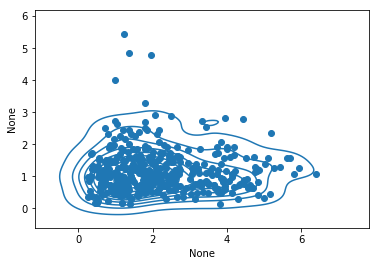

In [22]:
N = 1
M = 115

plt.scatter(norm_data[:, N].reshape(1, -1), norm_data[:, M].reshape(1, -1))
sns.kdeplot(x=norm_data[:, N].reshape(-1), y=norm_data[:, M].reshape(-1))

In [28]:
#pearson = pearson(norm_data, N, M)
mi_kde = mi_kde_norm(norm_data, N, M)
mi_knn = mi_knn_norm(norm_data, N, M)

print("KDE MI: ", round(mi_kde, 4))
print("KNN MI: ", round(mi_knn, 4))

# Aplicamos el coeficiente de correlacion generalizado de Lange
kde = (1 - np.exp(-2 * mi_kde)) ** 0.5
knn = (1 - np.exp(-2 * mi_knn)) ** 0.5

#print("\nPearson: ", round(pearson, 4))
print("KDE: ", round(kde, 4))
print("KNN: ", round(knn, 4))

KDE MI:  0.2925
KNN MI:  0.0794
KDE:  0.6655
KNN:  0.3832
